In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,LSTM,Dropout,Dense,BatchNormalization
from keras.models import Sequential

In [4]:
stock_list = {"Google": 2800,"Amazon": 3400,"Apple": 3400,"Microsoft": 3400,  "Tesla": 1800}

stock_name = ""
s_length = 0

def load_data():
    target_stock = pd.read_csv("./data/n_" + stock_name + ".csv")
    target_stock = pd.DataFrame(target_stock)
    # 时间点长度
    time_stamp = 50
    # 划分训练集与验证集
    target_stock = target_stock[['Open', 'High', 'Low', 'Close', 'Volume']]  # 'Volume'

    # 新增一列正负表示涨跌
    close = target_stock['Close'].tolist()
    y = []
    for i in range(len(target_stock) - 1):
        if close[i + 1] >= close[i]:
            y.append(1)
        else:
            y.append(-1)
    y.append(0)

    v4 = []
    for i in range(len(target_stock) - time_stamp - 1):
        if (y[i + time_stamp - 2] == 1):
            v4.append(1)
        else:
            v4.append(0)
    v4.append(0)
    target_stock["trend"] = y
    # 归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(target_stock)

    train = scaled_data[0:s_length + time_stamp]
    test = scaled_data[s_length - time_stamp:]
    # 训练集
    x_train, y_train = [], []
    for i in range(len(train) - time_stamp):
        train[i + time_stamp - 1][5] = v4[i]
        x_train.append(train[i:i + time_stamp])
        y_train.append(train[i + time_stamp, 3])

    x_train, y_train = np.array(x_train), np.array(y_train)
    # 测试集
    x_test, y_test = [], []
    for i in range(len(test) - time_stamp):
        test[i + time_stamp - 1][5] = v4[i + s_length - time_stamp]
        x_test.append(test[i:i + time_stamp])
        y_test.append(test[i + time_stamp, 3])

    x_test, y_test = np.array(x_test), np.array(y_test)

    return x_train, x_test, y_train, y_test

Epoch 1/300
85/85 [==============================] - 6s 37ms/step - loss: 0.0015 - val_loss: 4.1477e-05
Epoch 2/300
85/85 [==============================] - 2s 26ms/step - loss: 6.4616e-05 - val_loss: 1.7452e-04
Epoch 3/300
85/85 [==============================] - 2s 22ms/step - loss: 4.5371e-05 - val_loss: 2.9757e-05
Epoch 4/300
85/85 [==============================] - 2s 21ms/step - loss: 3.7784e-05 - val_loss: 3.5038e-05
Epoch 5/300
85/85 [==============================] - 2s 21ms/step - loss: 3.2799e-05 - val_loss: 2.9802e-05
Epoch 6/300
85/85 [==============================] - 2s 21ms/step - loss: 4.2925e-05 - val_loss: 3.5996e-05
Epoch 7/300
85/85 [==============================] - 2s 25ms/step - loss: 2.6247e-05 - val_loss: 5.4821e-05
Epoch 8/300
85/85 [==============================] - 2s 23ms/step - loss: 2.8986e-05 - val_loss: 9.7058e-05
Epoch 9/300
85/85 [==============================] - 2s 24ms/step - loss: 3.1501e-05 - val_loss: 3.3387e-05
Epoch 10/300
85/85 [============

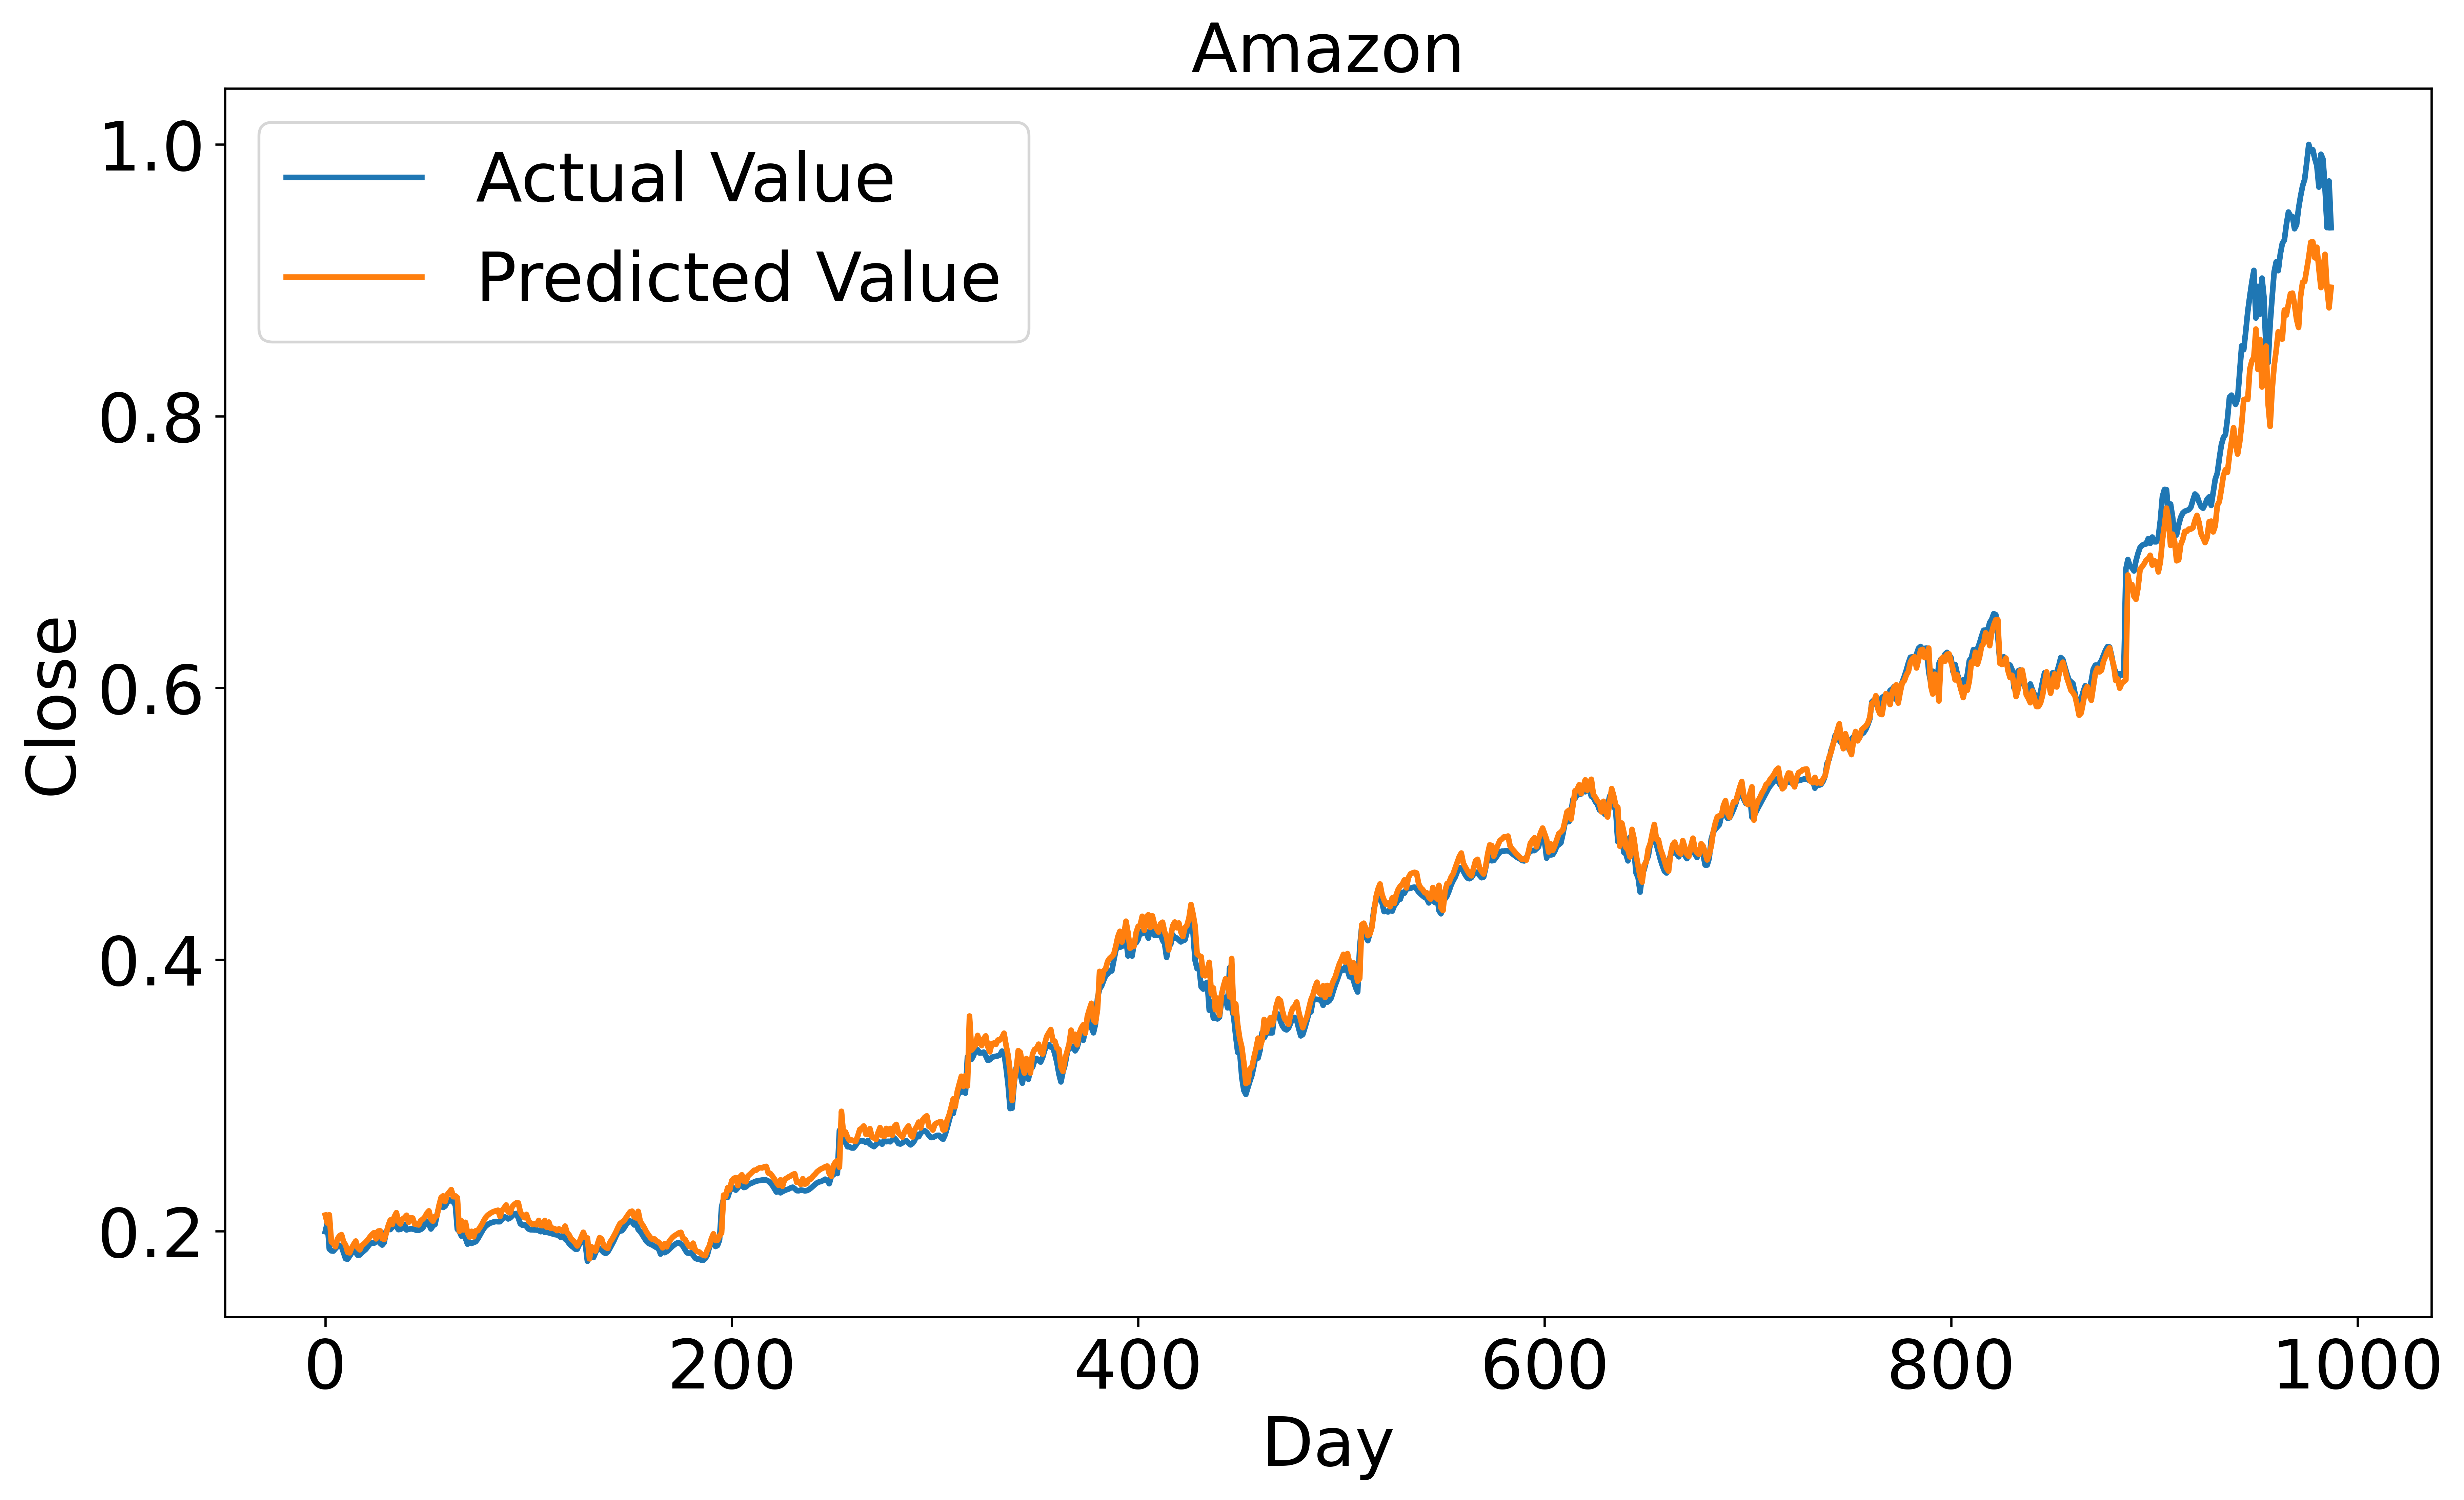

In [11]:
# 超参数
stock_name = "Amazon"
s_length = stock_list[stock_name]
epochs = 300
batch_size = 32
# LSTM 参数: return_sequences=True LSTM输出为一个序列。默认为False，输出一个值。
# input_dim：输入单个样本特征值的维度
# input_length：输入的时间点长度
x_train, x_test, y_train, y_test = load_data()
lstm_model = Sequential()
lstm_model.add(LSTM(units=47, return_sequences=True, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
# lstm_model.add(LSTM(units=106, input_dim=x_train.shape[-1], input_length=x_train.shape[1]))
lstm_model.add(LSTM(units=106))
lstm_model.add(Dense(78))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(74))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1,validation_split=0.2)
y_pre = lstm_model.predict(x_test)
fig_close = plt.figure(figsize=(14,8),dpi=600)
plt.plot(range(y_test.shape[0]),y_test,label="Actual Value",linewidth=2)
plt.plot(range(y_test.shape[0]),y_pre,label="Predicted Value",linewidth=2)
plt.title(stock_name,size=24)
plt.xlabel("Day",size=24)
plt.ylabel("Close",size=24)
plt.legend(fontsize=24)
plt.xticks(size=24)
plt.yticks(size=24)
fig_close.savefig(stock_name+"_Close.pdf",dpi=600)